#Extract useful information from text using Python and Machine Learning



Searching through text is one of the key focus areas of Machine Learning Applications in the field of Natural Language.
But what if we have to search for multiple keywords from a large document (100+ pages). Also, what if we have do a contextual search (searching for similar meaning keywords) with in our document! — The conventional ‘CTRL + F’ solution would either take long long hours to accomplish this task (or in case of contextual search, it will not be able to find any meaning text).
This article will help the readers understand how we can use Machine Learning to solve this problem using Spacy (a powerful open source NLP library) and Python.

<br/>

Original Source - https://towardsdatascience.com/natural-language-processing-document-search-using-spacy-and-python-820acdf604af 

<br/>

More on similar Words - https://towardsdatascience.com/how-to-build-a-fast-most-similar-words-method-in-spacy-32ed104fe498

#Data Pre-Processing
The initial step in any building any machine learning-based solution is pre-processing the data. In our case, we will be pre-processing a PDF document using PyPDF2 package in Python and then convert the entire text into a Spacy document object. For readers who have not worked on Spacy — It is an advanced open source library in Python used for various NLP tasks. For users who are interested in learning more about Spacy, please refer this link for reading the documentation and learning more about Spacy — https://spacy.io/
We will first load the PDF document, clean the text and then convert it into Spacy document object. The following code can be used to perform this task-


In [4]:
!pip install PyPDF2
!pip install spacy

In [10]:
import spacy
import PyPDF2

# spacy english model (large)
nlp = spacy.load('en_core_web_sm')



In [11]:
# method for reading a pdf file
def readPdfFile(filename, folder_name):
    
    # storing path of PDF-Documents folder
    data_path = str(os.getcwd()) + "\\" + folder_name

    file = open(data_path + "\\" + filename, mode="rb")

    # looping through pdf pages and storing data
    pdf_reader = PyPDF2.PdfFileReader(file)
    num_pages = pdf_reader.numPages

    # traverse through each page and store data as an element in list
    text = []
    for pages in range(0, num_pages):
        current_page = pdf_reader.getPage(pages)
        text.append(current_page.extractText().replace("\n","").lower())

    # # remove \n from list
    # text = [t.replace("\n", "").lower() for t in text]

    # store content of 1-last page in a seperate list
    rest_pages = []
    for t in text[1:]:
        rest_pages.append(t[115:])

    # store 0th page content separately
    first_page = [text[0][850:]]

    # storing the 0th and 1-last page content after cleaning in text
    text = first_page + rest_pages
    
    # creating a single string containing full text
    full_text = "".join(text)

    return full_text


# customer sentence segmenter for creating spacy document object
def setCustomBoundaries(doc):
    # traversing through tokens in document object
    for token in doc[:-1]:
        if token.text == ';':
            doc[token.i + 1].is_sent_start = True
        if token.text == ".":
            doc[token.i + 1].is_sent_start = False
    return doc


# create spacy document object from pdf text
def getSpacyDocument(pdf_text, nlp):
    main_doc = nlp(pdf_text)  # create spacy document object

    return main_doc

# adding setCusotmeBoundaries to the pipeline
nlp.add_pipe(setCustomBoundaries, before='parser')

#Getting set up
First we will have to load Spacy’s ‘en_core_web_lg’ model which is a pre-trained English language model available in Spacy. Spacy also provides support for multiple languages (more can be found in the documentation link). Also, Spacy has multiple variations for models (small, medium and large) and for our case we will be working with large model since we have to work with word vectors which is only supported with the large model variant.



The ‘setCustomBoundaries()’ is used as a customer sentence segmentation method as opposed to the default option. The same method can be modified depending upon the document we are dealing.
Once we have the Spacy’s document object ready, we can move to the next part of handling the input query (keywords) that we need to search for in the document.


#Handling Query — Finding Similar Keywords
Before moving on to the coding part, let's look at the broader approach we are following in order to get more accurate search results from the document we are searching.

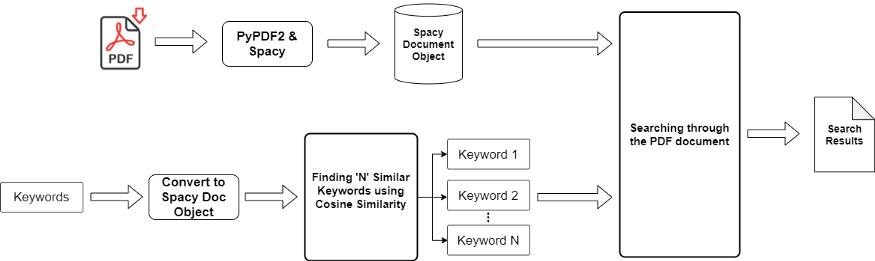

Up until the data preprocessing stage we have already converted our PDF document text to Spacy’s document object. Now we also have to convert our keywords to Spacy’s document object, convert them into their equivalent vector form ((300, ) dimension) and then finding similar keywords using the cosine similarity. At the end we will have an exhaustive list of similar keywords along with the original keywords that we can now search through our document to generate accurate results.

Refer the below code to perform this task-


In [26]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 13.0 MB/s 
     |████████████████████████████████| 596 kB 60.3 MB/s 
     |████████████████████████████████| 6.8 MB 48.6 MB/s 
     |████████████████████████████████| 895 kB 74.3 MB/s 
     |████████████████████████████████| 67 kB 6.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [31]:
import difflib

res = difflib.get_close_matches('anlmal', ['human','car', 'animal','animals', 'house', 'animation','creature', 'ninjas', 'hats','dirty', 'dog'])

res

['animal', 'animals']

In [21]:
!pip install textblob

In [22]:
from textblob import TextBlob
 
a = "cmputr"           # incorrect spelling
print("original text: "+str(a))
 
b = TextBlob(a)
 
# prints the corrected spelling
print("corrected text: "+str(b.correct()))

original text: cmputr
corrected text: computer


In [24]:

def checkspelling(word):
  checked = TextBlob(word)
  if(word == checked):
    return True
  else:
    return False


# convert keywords to vector
def createKeywordsVectors(keyword, nlp):
    doc = nlp(keyword)  # convert to document object

    return doc.vector


# method to find cosine similarity
def cosineSimilarity(vect1, vect2):
    # return cosine distance
    return 1 - spatial.distance.cosine(vect1, vect2)


# method to find similar words
def getSimilarWords(keyword, nlp):
    similarity_list = []

    keyword_vector = createKeywordsVectors(keyword, nlp)

    for tokens in nlp.vocab:
        if (tokens.has_vector):
            if (tokens.is_lower):
                if (tokens.is_alpha):
                    similarity_list.append((tokens, cosineSimilarity(keyword_vector, tokens.vector)))

    similarity_list = sorted(similarity_list, key=lambda item: -item[1])
    similarity_list = similarity_list[:30]

    top_similar_words = [item[0].text for item in similarity_list]

    top_similar_words = top_similar_words[:3]
    top_similar_words.append(keyword)

    for token in nlp(keyword):
        top_similar_words.insert(0, token.lemma_)

    for words in top_similar_words:
        if words.endswith("s"):
            top_similar_words.append(words[0:len(words)-1])

    top_similar_words = list(set(top_similar_words))

    top_similar_words = [words for words in top_similar_words if checkspelling(words) == True]

    return ", ".join(top_similar_words)

  
keywords = ['label', 'package']
keywordsets=[]
for x in keywords:
  similar_keywords = getSimilarWords(x, nlp)
  keywordsets.append(similar_keywords)

keywordsets

['label', 'package']

#Finding Matches
Now that we have found contextually similar words to our original keywords, let's work on the final searching part.
Searching Keywords through Text
For searching, we would be using the PhraseMatcher class of Spacy’s Matcher class. At this point, it is important to remember that Spacy’s document object is not as same as a simple python string and hence we cannot directly use if then else to find the results.

<br/>

Refer to the below code to perform this task-

In [33]:
from spacy.matcher import PhraseMatcher
from scipy import spatial

# method for searching keyword from the text
def search_for_keyword(keyword, doc_obj, nlp):
    phrase_matcher = PhraseMatcher(nlp.vocab)
    phrase_list = [nlp(keyword)]
    phrase_matcher.add("Text Extractor", None, *phrase_list)

    matched_items = phrase_matcher(doc_obj)

    matched_text = []
    for match_id, start, end in matched_items:
        text = nlp.vocab.strings[match_id]
        span = doc_obj[start: end]
        matched_text.append(span.sent.text)
    
    return matched_text

The above code will search for every keyword we have through the entire text and will return us the entire sentence wherever it has found a match.



#Final Notes
You can increase or decrease the number of similar keywords that you want to find for any original keywords. Also, once you get the results in a dataframe, you can simply add some more logics for ranking the results (give more weightage to exact keyword match and so on).

Note: Increasing number of Similar Keywords to large number may increase the computational cost of the overall program and hence should be chosen wisely.

So this is how you can create your own ML based Python program for performing search through any text.
In case of any other input source (Photographs, Web pages etc.) you just need to customize the data preprocessing part (OCR, Web Scraping etc.) and the rest of the logic should perform just fine.